Atalov S. (TSI AUCA)

---

# Lab3. Passenger Satisfaction
- **5 points**
- **Submit:** csv file and this notebook
- **Deadline:** Mar 29, 23:59.

This task is devoted to a full-fledged solution to the problem of machine learning.

<div>
    <img src="https://live-production.wcms.abc-cdn.net.au/ac56ffe2b5282f82358e6b396e2da2ba?impolicy=wcms_crop_resize&cropH=1915&cropW=3404&xPos=5&yPos=0&width=862&height=485" width="500"/>
</div>


---

## 0. Problem Statement

About Company:

**TSI Airlines** - largest airline of Kyrgyzstan by size and passengers carried.

#### Problem
You need to create a model that will accurately predict passenger **satisfaction**.

In [81]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
df = pd.read_csv("satisfaction_train.csv")


In [82]:
df

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,87265,Male,Loyal Customer,25,Business travel,Business,3904,4,4,1,...,5,3,3,4,4,5,5,0,0.0,satisfied
1,65499,Female,disloyal Customer,26,Business travel,Business,1067,5,5,5,...,4,3,2,5,3,5,4,0,0.0,satisfied
2,10789,Female,Loyal Customer,55,Business travel,Business,3953,4,5,5,...,4,4,4,4,4,4,4,0,11.0,neutral or dissatisfied
3,5490,Male,Loyal Customer,32,Business travel,Eco,910,1,1,1,...,1,1,1,4,4,3,1,0,0.0,neutral or dissatisfied
4,99452,Female,Loyal Customer,36,Business travel,Business,283,1,1,1,...,5,5,5,5,3,5,3,17,20.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,40802,Female,disloyal Customer,26,Business travel,Eco,532,2,3,2,...,3,5,2,3,2,3,3,0,0.0,neutral or dissatisfied
79996,97109,Male,disloyal Customer,29,Business travel,Business,1476,5,5,5,...,4,4,5,4,4,4,4,3,0.0,satisfied
79997,92611,Female,Loyal Customer,33,Business travel,Eco Plus,2342,4,3,3,...,4,1,4,3,4,3,4,0,0.0,neutral or dissatisfied
79998,67394,Female,disloyal Customer,25,Business travel,Eco,592,4,3,4,...,1,3,4,4,1,4,1,2,12.0,neutral or dissatisfied


## 1. Data Preprocessing

In [83]:
df = df.drop(columns=['id'])

In [84]:
df.isnull().sum()

Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             226
satisfaction                           0
dtype: int64

In [85]:
numerical_cols = [ "Arrival Delay in Minutes" ]

In [86]:
def fill_missing_values(df: pd.DataFrame, strategy: str ='mean') -> pd.DataFrame:
    """Заполнение пустых значений указанными стратегиями"""
    df = df.copy()
    fill_value = 0
    for column in df.columns:
        if strategy == 'mean':
            fill_value = df[column].mean()
        elif strategy == 'median':
            fill_value = df[column].median()
        elif strategy == 'mode':
            fill_value = df[column].mode()[0] # берем первую моду
            
        ### TO DO
        df[column].fillna( value = fill_value, inplace=True )
    return df

In [87]:
df[numerical_cols] = fill_missing_values( df[numerical_cols] )


In [88]:
df.dtypes

Gender                                object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
Cleanliness                            int64
Departure Delay in Minutes             int64
Arrival Delay in Minutes             float64
satisfacti

In [89]:
categorical_cols = [ "Gender", "Customer Type" ,"Type of Travel","Class","satisfaction"]

In [90]:
def one_hot_encoder(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """Категорийные данные в численные"""
    df = df.copy()
    # Убираем численные столбцы - их не трогаем
    df_num = df.drop(columns = columns)
    
    # В датафрейме оставляем только категорийные столбцы
    df = df[columns].copy()
    
    # Новый датафрейм который будем возвращать
    df_prep = pd.DataFrame()
    
    for column in df.columns:
        # Уникальные значения столбца
        unique_values = df[column].unique()
        # Если уникальных значений меньше 2, то просто replace
        if len(unique_values) <= 2:
            df_prep[column] = df[column]
            for i in range(len(unique_values)):
                df_prep[column] = df_prep[column].replace({unique_values[i]: i})
        else: # Иначе get_dummies
            dummies = pd.get_dummies( df[column], prefix=column )
            df_prep = pd.concat([df_prep, dummies], axis=1)
    
    # Соединяем численные и категорийные столбцы
    return pd.concat([df_num, df_prep], axis=1)

In [91]:
df = one_hot_encoder( df, categorical_cols )

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                80000 non-null  int64  
 1   Flight Distance                    80000 non-null  int64  
 2   Inflight wifi service              80000 non-null  int64  
 3   Departure/Arrival time convenient  80000 non-null  int64  
 4   Ease of Online booking             80000 non-null  int64  
 5   Gate location                      80000 non-null  int64  
 6   Food and drink                     80000 non-null  int64  
 7   Online boarding                    80000 non-null  int64  
 8   Seat comfort                       80000 non-null  int64  
 9   Inflight entertainment             80000 non-null  int64  
 10  On-board service                   80000 non-null  int64  
 11  Leg room service                   80000 non-null  int

## 2. Modeling

In [92]:
X = df.copy()

y = X.pop('satisfaction')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [97]:
model = RandomForestClassifier(
    max_depth = 7,
    min_samples_split = 5,
    n_estimators = 120
)


In [98]:
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
model.score(X_test, y_test)

0.93384375


0.9338125

## 3. Hyperparameter Tuning (Find Best Parameters)

In [95]:
test_scores = []
train_scores = []
for i in range(1, 30):
    model = DecisionTreeClassifier(random_state = 0, max_depth = i)
    model.fit(X_train, y_train)
    
    train_scores.append( model.score(X_train, y_train) )

    test_scores.append( model.score(X_test, y_test) )

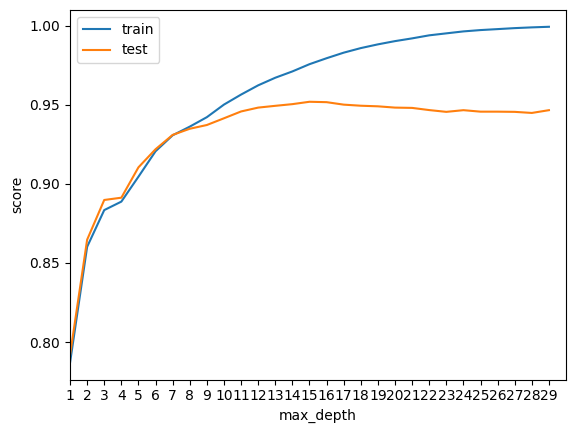

In [96]:
plt.plot(range(1, 30), train_scores, label='train');
plt.plot(range(1, 30), test_scores, label='test');
plt.xlabel('max_depth');
plt.ylabel('score');
plt.xlim(1, 30);
plt.xticks(range(1, 30))
plt.legend()
plt.show();

In [99]:
list_n_estimators = [10, 30, 50, 70, 100, 120, 150, 200, 300]
list_max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
list_min_samples_split = [2, 3, 5, 7, 9, 11, 15]
from sklearn.model_selection import GridSearchCV

In [100]:
grid = {'n_estimators': list_n_estimators,
        'max_depth': list_max_depth,
        'min_samples_split': list_min_samples_split}
model = RandomForestClassifier(random_state = 0)

In [101]:
search = GridSearchCV(estimator = model,
                      param_grid = grid,
                      n_jobs = -1,
                      cv = 3)   

In [102]:
%%time
search.fit(X_train, y_train)

CPU times: total: 32.4 s
Wall time: 18min 18s


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_split': [2, 3, 5, 7, 9, 11, 15],
                         'n_estimators': [10, 30, 50, 70, 100, 120, 150, 200,
                                          300]})

In [103]:
search.best_params_

{'max_depth': 10, 'min_samples_split': 9, 'n_estimators': 50}

In [163]:
model = RandomForestClassifier(
    max_depth = 10,
    min_samples_split = 9,
    n_estimators = 50
)

model.fit(X_train, y_train)
print(model.score(X_train, y_train))
model.score(X_test, y_test)

0.947203125


0.94325

## 4. Write Pipeline For Data Preparation and Prediction

In [174]:

import pickle
filename = 'my_model.pkl'
pickle.dump(model, open(filename, 'wb'))

In [175]:
df_test = pd.read_csv("satisfaction_test.csv")

In [176]:
categorical_cols1 = [ "Gender", "Customer Type" ,"Type of Travel","Class"]

In [177]:
def make_predictions(X: pd.DataFrame, model_name: str) -> np.array:
    
    X = X.drop(columns=['id'])
    X[numerical_cols] = fill_missing_values( X[numerical_cols] )
    X[categorical_cols1] = fill_missing_values( X[categorical_cols1], strategy='mode' )
    
    X = one_hot_encoder( X, categorical_cols1 )
    
    return predict(X, model_name)



## 5. Predict Test Data

### Read and Prepare test data using your pipeline

In [178]:
def predict(data, model_name):
    with open(model_name, 'rb') as file:
        model = pickle.load(file)
        
    y_pred = model.predict(data)
    return y_pred

In [179]:
make_predictions(df_test, "my_model.pkl")

array([0, 0, 1, ..., 0, 1, 1], dtype=int64)

### Make a prediction using your best model:

In [180]:
y_pred = make_predictions(df_test, "my_model.pkl")

df_predictions = pd.DataFrame({
    'satisfaction': y_pred
})


In [173]:
df_predictions

,satisfaction
0,0
1,0
2,1
3,0
4,0
...,...
23899,0
23900,1
23901,0
23902,1


### Save predictions as `YourName.csv` and submit csv file and this notebook in ecourse

HINT: Use `df.to_csv('YourName.csv', index=False)`

In [181]:

df_predictions.to_csv('kalbaev_timur.csv', index=False)